In [1]:
import pickle
import numpy as np
from reduction.api import Features, Instance, AdjacentOrNot, Relation, Rule, Statement
from reduction.extract_rules import extract_rules
from reduction.measure_adjacencies import measure_rules, measure
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from joblib import Parallel, delayed
from mlxtend.plotting import plot_decision_regions
from sklearn.datasets import make_moons
from toolz.curried import pipe, map, filter, reduce

In [2]:
from collections import defaultdict, OrderedDict
def classify_single_value(x, rules):
    instance = to_instance(x)
    supports = defaultdict(lambda: 0)
    
    for rule in rules:
        
        if rule.describes(instance):
            supports[rule.get_classified_class()] = supports[rule.get_classified_class()] + 1
         
    if not supports:
        return None
    return max(supports, key=supports.get)



In [3]:
def classify_normal(x, y, rules):
    yNew = []
    for inst in x:
        classified_class = classify_single_value(inst, rules)

        yNew.append(classified_class)
            
    return yNew

In [46]:
def get_measure(x, y, rules):
    measurements = measure_rules(rules)
    meas_ratio = len([m for m in measurements.values() if m == AdjacentOrNot.NOT_ADJACENT])/len(measurements)
    
    labelki = np.unique([r.get_classified_class() for r in rules])
    
    acc = sum([1 for y_pred, y_true in zip(classify_normal(x,y,rules), y) if y_pred == y_true])/len(y)
    return 0.5 * meas_ratio + 0.5 * acc

In [5]:
x, y = make_moons(n_samples=25, noise=0.3)
clf = RandomForestClassifier(n_estimators=25, max_depth=5)
clf.fit(x,y)

RandomForestClassifier(max_depth=5, n_estimators=25)

In [6]:
features = Features({
    0: "a",
    1: "b"
})

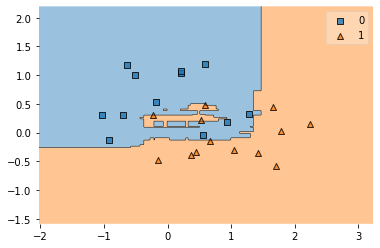

In [7]:
plot_decision_regions(x, y, clf=clf)

In [8]:
def join_consecutive_statements(rule: Rule) -> Rule:
    all_statements = set()
    for feature in features.get_all():
        statements = rule.get_statements_for_feature(feature)
        new_this_rule_statements = set(statements)
        
        sorted_by_threshold = iter(sorted(statements, key=lambda s: s.threshold))
        try:
            current_statement = next(sorted_by_threshold)
            while(True):
                next_statement = next(sorted_by_threshold)
                
                if current_statement.relation == next_statement.relation:
                    if current_statement.relation == Relation.MT:
                        new_this_rule_statements.remove(next_statement)
                    else:
                        new_this_rule_statements.remove(current_statement)
                        
                current_statement = next_statement
        except StopIteration:
            pass
        
        all_statements = all_statements.union(new_this_rule_statements)
        
    return Rule(statements=all_statements, examples_distribution=rule.examples_distribution)
                        
        

In [9]:
def bound_if_needed(rule: Rule, statement: Statement) -> Rule:
    statements = set(rule.get_statements_for_feature(statement.feature)).difference({statement})
    all_rule_statements_without_this_feature = set(rule.statements).difference(statements)
    new_statements = set()
    next_higher = pipe(
        statements,
        filter(lambda s: s.threshold > statement.threshold),
        list
    )
    
    next_lower = pipe(
        statements,
        filter(lambda s: s.threshold < statement.threshold),
        list
    )
    
    if statement.relation == Relation.LEQ and not any(next_lower):
        new_statements.add(Statement(statement.feature, Relation.MT, feature_lowest[statement.feature.index]))
    elif statement.relation == Relation.MT and not any(next_higher):
        new_statements.add(Statement(statement.feature, Relation.LEQ, feature_maxes[statement.feature.index]))
    else:
        return set()
    
    
    return new_statements
    

In [10]:
def bound_rule(rule: Rule) -> Rule:
    new_statements_for_rule = set(rule.get_statements())
    for statement in rule.statements:
        new_statements_for_rule = new_statements_for_rule.union(bound_if_needed(rule, statement))
        
    return Rule(new_statements_for_rule, rule.examples_distribution)

In [11]:
feature_maxes = np.max(x, axis=0)
feature_lowest = np.min(x, axis=0)
feature_ranges = np.ptp(x, axis=0)

In [12]:
from typing import Set

In [13]:
%%time

all_rules = pipe(
    clf.estimators_,
    map(lambda estimator: extract_rules(estimator, features)),
    reduce(list.__add__),
    map(join_consecutive_statements),
    map(bound_rule),
    list
)
all_rule_measurements = measure_rules(all_rules)

CPU times: user 921 ms, sys: 138 ms, total: 1.06 s
Wall time: 1.87 s


In [14]:
def split_rule_to_hyperrect_if_needed(rule: Rule) -> Set[Rule]:
    
    
    new_rules = set()
    for feature in features:
        statements = rule.get_statements_for_feature(feature)
        other_features_statements = set(rule.get_statements()).difference(statements)

        if len(statements) > 2:

            statements_sorted = pipe(statements,
                list,
                lambda statementsList: sorted(statementsList, key=lambda s: s.threshold),
                 iter
            )

            for statement_lower in statements_sorted:
                statement_higher = next(statements_sorted)
                
                new_rule = Rule(statements=other_features_statements.union({statement_lower, statement_higher}), examples_distribution=rule.examples_distribution)
                
                new_rules.add(new_rule)
                
    
    if len(new_rules) == 0:
        return {rule}
    return new_rules

            
    
            

In [15]:
def to_instance(x):
    return Instance(dict(zip(features.get_all(), x)))    

In [16]:
def filtered_rules(rule: Rule, adjacency: AdjacentOrNot) -> Set[Rule]:
    all_but_this = set(all_rules).difference({rule})
    return pipe(all_but_this,
        map(lambda r: (r, measure((rule, r)))),
        filter(lambda tple: tple[1] == adjacency),
        map(lambda tple: tple[0]),
         set
    )


In [17]:
def rule_accuracy(rule: Rule):
    correct_predictions = 0
    wrong_predictions = 0
    for x_inst, y_inst in zip(x, y):
        x_inst = to_instance(x_inst)
        if rule.describes(x_inst):
            if y_inst == rule.get_classified_class():
                correct_predictions = correct_predictions + 1
            else:
                wrong_predictions = wrong_predictions + 1
    return correct_predictions/(correct_predictions + wrong_predictions)

In [18]:
def rules_distance(rule1: Rule, rule2: Rule) -> float:
    vector = []
    for feature in features.get_all():
        
        rule_1_statements_for_feature = rule1.get_statements_for_feature(feature)
        rule_2_statements_for_feature = rule2.get_statements_for_feature(feature)
        
        
        if len(rule_1_statements_for_feature) == 0 or len(rule_2_statements_for_feature) == 0:
            vector.append(None)
        else:
            rule1_min, rule1_max = pipe(
                rule_1_statements_for_feature,
                map(lambda s: s.threshold),
                lambda statements: sorted(statements),
                list
            )
            rule2_min, rule2_max = pipe(
                rule_2_statements_for_feature,
                map(lambda s: s.threshold),
                lambda statements: sorted(statements),
                list
            )
            
            if rule1_min <= rule2_min <= rule1_max or rule2_min <= rule1_min <= rule2_max or rule1_min <= rule2_max <= rule1_max or rule2_min <= rule1_max <= rule2_max:
                vector.append(0)
            elif rule1_min > rule2_max:
                vector.append(rule1_min - rule2_max)
            elif rule2_min > rule1_max:
                vector.append(rule2_min - rule1_max)
            elif rule1_min < rule2_max:
                vector.append(rule2_max - rule1_min)
            elif rule2_min < rule1_max:
                vector.append(rule1_max - rule2_min)
                
                
    vector_final = [(val/feature_ranges[idx])**2 for idx, val in enumerate(vector) if val is not None]
    not_none_count = len([_ for _ in vector if _ is not None])
    
    return np.sqrt(sum(vector_final))/not_none_count

In [19]:

rules_distance(all_rules[0], all_rules[2])

0.0

In [20]:
def find_n_closest_rules(rule: Rule, n:int, all_rules):
    without_current = set(all_rules).difference({rule})
    return pipe(without_current,
        map(lambda r: (rules_distance(r, rule), r)),
         list,
        lambda l: sorted(l, key=lambda i: i[0]),
        map(lambda l: l[1]),
         list,
        lambda l: l[:n]
    )    

In [21]:
def vectorize(rule: Rule):
    vector = []
    for feature in features.get_all():
        statements = rule.get_statements_for_feature(feature)
        
        if len(statements) == 0:
            vector.append(0)
            vector.append(0)
        else:
            min_val, max_val = pipe(statements,
                map(lambda s: s.threshold),
                sorted,
                list)

            vector.append(min_val)
            vector.append(max_val)
        
    return vector

In [22]:
vectorize(all_rules[70])

[-0.432099886238575,
 1.3531060218811035,
 -0.17051148042082787,
 0.7731719315052032]

In [25]:
def modify_feature(rule: Rule, feature: Features, lower_or_upper: str, multiplier: float) -> Rule:
    statements = set(rule.get_statements_for_feature(feature))
    other_features_statements = set(rule.statements).difference(statements)
    
    if lower_or_upper == 'upper':
        statement_to_modify = max(statements, key=lambda s: s.threshold)
        new_statement = Statement(statement_to_modify.feature, statement_to_modify.relation, statement_to_modify.threshold * multiplier)
        
    elif lower_or_upper == 'lower':
        statement_to_modify = min(statements, key=lambda s: s.threshold)
        new_statement = Statement(statement_to_modify.feature, statement_to_modify.relation, statement_to_modify.threshold * multiplier)
    else:
        raise Exception('wrong')
        

    new_rule_statements = other_features_statements.union(statements.difference({statement_to_modify})).union({new_statement})
    
    return Rule(new_rule_statements, rule.examples_distribution)

In [69]:
import gym
from gym import spaces
import random
from copy import deepcopy


class CustomEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, all_rules):
        super(CustomEnv, self).__init__()
        
        self.original_rules = all_rules
        self.current_rules = set(deepcopy(self.original_rules))
        self.selected_rule = random.choice(list(self.current_rules))
        self.iteration = 0

        self.current_rule_neighbour = self._update_observation_space()
        
        
        classified_class = spaces.MultiDiscrete([2, 2, 2, 2])
        
        rule_data = spaces.Box(
            low=np.full((5, 5), -10), high=np.full((5, 5), 10), dtype=np.float16)
        
        
        self.action_space = spaces.Discrete(10)
        
        # Example for using image as input:
        self.observation_space = rule_data

    def step(self, action):
        
        if action == 0: # extend lower a
            feature = features.get_by_index(0)
            if len(self.selected_rule.get_statements_for_feature(feature)) > 0: 
                new_rule = modify_feature(self.selected_rule, feature, 'lower', 0.1)
                self.current_rules = self.current_rules.difference({self.selected_rule}).union({new_rule})
                self.selected_rule = new_rule
        if action == 1: # extend upper a
            feature = features.get_by_index(0)
            if len(self.selected_rule.get_statements_for_feature(feature)) > 0: 
                new_rule = modify_feature(self.selected_rule, feature, 'upper', 0.1)
                self.current_rules = self.current_rules.difference({self.selected_rule}).union({new_rule})
                self.selected_rule = new_rule
        if action == 2: # extend lower b
            feature = features.get_by_index(1)
            if len(self.selected_rule.get_statements_for_feature(feature)) > 0: 
                new_rule = modify_feature(self.selected_rule, feature, 'lower', 0.1)
                self.current_rules = self.current_rules.difference({self.selected_rule}).union({new_rule})
                self.selected_rule = new_rule
        if action == 3: # extend upper b
            feature = features.get_by_index(1)
            if len(self.selected_rule.get_statements_for_feature(feature)) > 0: 
                new_rule = modify_feature(self.selected_rule, feature, 'upper', 0.1)
                self.current_rules = self.current_rules.difference({self.selected_rule}).union({new_rule})
                self.selected_rule = new_rule
        if action == 4: # shrink lower a
            feature = features.get_by_index(0)
            if len(self.selected_rule.get_statements_for_feature(feature)) > 0: 
                new_rule = modify_feature(self.selected_rule, feature, 'lower', -0.1)
                self.current_rules = self.current_rules.difference({self.selected_rule}).union({new_rule})
                self.selected_rule = new_rule
        if action == 5: # shrink upper a
            feature = features.get_by_index(0)
            if len(self.selected_rule.get_statements_for_feature(feature)) > 0: 
                new_rule = modify_feature(self.selected_rule, feature, 'upper', -0.1)
                self.current_rules = self.current_rules.difference({self.selected_rule}).union({new_rule})
                self.selected_rule = new_rule
        if action == 6: # shrink lower b
            feature = features.get_by_index(1)
            if len(self.selected_rule.get_statements_for_feature(feature)) > 0: 
                new_rule = modify_feature(self.selected_rule, feature, 'lower', -0.1)
                self.current_rules = self.current_rules.difference({self.selected_rule}).union({new_rule})
                self.selected_rule = new_rule
        if action == 7: # shrink upper b
            feature = features.get_by_index(1)
            if len(self.selected_rule.get_statements_for_feature(feature)) > 0: 
                new_rule = modify_feature(self.selected_rule, feature, 'upper', -0.1)
                self.current_rules = self.current_rules.difference({self.selected_rule}).union({new_rule})
                self.selected_rule = new_rule
        if action == 8: # delete rule
            self.current_rules = self.current_rules.difference({self.selected_rule})
            self.selected_rule = self.current_rule_neighbour[0]
        if action == 9: # switch to next rule
            self.selected_rule = self.current_rule_neighbour[0]
            
        self._update_observation_space()
        reward = get_measure(x,y,self.current_rules)
        
        done = False if self.iteration % 100 != 0 else len([m for m in measure_rules(self.current_rules).values() if m == AdjacentOrNot.ADJACENT]) == 0 
        
        done = done if len(self.current_rules) != 6 else True
        
        return self._get_observation(), reward, done, {}
          
        
    
    def _update_observation_space(self):
        self.iteration = self.iteration + 1
        self.current_rule_neighbour = self._get_neighbors(self.selected_rule)
    
    def _get_observation(self):
        rulez = [self.selected_rule] + self.current_rule_neighbour
        vectorized = pipe(rulez,
            map(vectorize),
            list,
             np.array)

        classes = pipe(rulez,
            map(lambda r: r.get_classified_class()),
            list,
        np.array)
        
        return np.hstack([vectorized, classes.reshape(5,1)])
        
    def _get_neighbors(self, rule: Rule):
        return find_n_closest_rules(rule, 4, self.current_rules)
        
    def reset(self):
        self.current_rules = set(deepcopy(self.original_rules))
        self.selected_rule = random.choice(list(self.current_rules))
        self.current_rule_neighbour = self._update_observation_space()
        self.iteration = 0
        
        return self.observation_space.sample()  # reward, done, info can't be included
    def render(self, mode='human', close=False):
        print(f"rules = {len(self.current_rules)}")


In [27]:

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [47]:

from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3 import A2C

In [63]:
model.save("a2c_rules")

In [73]:

env.reset()
obs = env.observation_space.sample()
for i in range(200):
    action, _states = model.predict(obs)
    print(f"act = {action}")
    obs, rewards, dones, info = env.step(action)
    env.render()


act = 2
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142
act = 5
rules = 142


In [ ]:
env = CustomEnv(all_rules)

model = A2C(ActorCriticPolicy, env, verbose=1)
model.learn(total_timesteps=25000)

<ipython-input-18-98e2ea23743d>:40: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(sum(vector_final))/not_none_count
/opt/conda/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Using cpu device
Wrapping the env in a DummyVecEnv.
------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 100      |
|    time_elapsed       | 412      |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -2.07    |
|    explained_variance | -98.9    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 2.75     |
|    value_loss         | 1.81     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 200      |
|    time_elapsed       | 736      |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -1.73    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss       